In [1]:
from __future__ import print_function

%matplotlib inline

import sys
import tensorflow as tf

import numpy as np
import scipy.misc
from input import *
from model import *
import matplotlib.pyplot as plt

In [2]:
iterator, filename = get_train_inputs(batch_size=100,repeat=False,num_classes=2)

(375, 1242, 3)


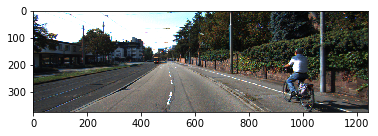

In [3]:
with tf.Session() as sess:
    sess.run(iterator.initializer, feed_dict={filename: ['data/kitti_segmentation.tfrecord']})
    next_element = iterator.get_next()
    image, label = sess.run(next_element)
    print(image.shape)
    plt.imshow(image)
    #plt.imshow(label[:,:,0], cmap='jet', alpha=0.5)

In [ ]:
# record_iterator = tf.python_io.tf_record_iterator(path='data/kitti_segmentation.tfrecord')
# string_record = next(record_iterator)
# example = tf.train.Example()
# example.ParseFromString(string_record)

# train

In [3]:
encoder = SlimModelEncoder(name="vgg_16",num_classes=2,is_training=True)

In [4]:
image, label = iterator.get_next()
image.get_shape()
init_fn, end_points = encoder.build(image)

INFO:tensorflow:Scale of 0 disables regularizer.


In [6]:
end_points

OrderedDict([('vgg_16/conv1/conv1_1',
              <tf.Tensor 'vgg_16/conv1/conv1_1/Relu:0' shape=(1, 224, 224, 64) dtype=float32>),
             ('vgg_16/conv1/conv1_2',
              <tf.Tensor 'vgg_16/conv1/conv1_2/Relu:0' shape=(1, 224, 224, 64) dtype=float32>),
             ('vgg_16/pool1',
              <tf.Tensor 'vgg_16/pool1/MaxPool:0' shape=(1, 112, 112, 64) dtype=float32>),
             ('vgg_16/conv2/conv2_1',
              <tf.Tensor 'vgg_16/conv2/conv2_1/Relu:0' shape=(1, 112, 112, 128) dtype=float32>),
             ('vgg_16/conv2/conv2_2',
              <tf.Tensor 'vgg_16/conv2/conv2_2/Relu:0' shape=(1, 112, 112, 128) dtype=float32>),
             ('vgg_16/pool2',
              <tf.Tensor 'vgg_16/pool2/MaxPool:0' shape=(1, 56, 56, 128) dtype=float32>),
             ('vgg_16/conv3/conv3_1',
              <tf.Tensor 'vgg_16/conv3/conv3_1/Relu:0' shape=(1, 56, 56, 256) dtype=float32>),
             ('vgg_16/conv3/conv3_2',
              <tf.Tensor 'vgg_16/conv3/conv3_2/Rel